In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pio.renderers.default = "png"

from data import *
from plotting import *
from regression import *
from utils import *




In [3]:
# Load data
pcd_df = load_pcd_df()

access_df = pcd_df.dropna(subset=['Model accessibility'])
len(access_df)

971

# Model Accessibility Charts

In [28]:
# Add year column
access_df['Year'] = pd.to_datetime(access_df['Publication date']).dt.year

# Get counts of all models by year and model accessibility
# Only include 2015 and later because older models are rare
access_counts = access_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model accessibility']).size().reset_index(name='Count')

# Add up cumulative counts by accessibility status for each year 
access_counts['Cumulative for status'] = access_counts.groupby('Model accessibility')['Count'].cumsum()

# Sort from most closed to most open
sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open access (non-commercial)', 'Open access (restricted use)', 'Open source']
access_counts['Category_sorted'] = pd.Categorical(access_counts['Model accessibility'], categories=sort_order, ordered=True)
access_counts = access_counts.sort_values(['Category_sorted', 'Year'])

access_counts.head(20)

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_74801/399375725.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Year     Model accessibility  Count  Cumulative for status  \
1   2015              Unreleased      6                      6   
5   2016              Unreleased     19                     25   
7   2017              Unreleased     30                     55   
10  2018              Unreleased     45                    100   
14  2019              Unreleased     93                    193   
18  2020              Unreleased     55                    248   
23  2021              Unreleased     74                    322   
29  2022              Unreleased     47                    369   
35  2023              Unreleased     37                    406   
41  2024              Unreleased     14                    420   
2   2016  Hosted access (no API)      1                      1   
11  2019  Hosted access (no API)      1                      2   
20  2021  Hosted access (no API)      2                      4   
25  2022  Hosted access (no API)      3                      7   
31  2023  Hosted access (no API)     10                     17   
37  2024  Hosted access (no API)      6                     23   
15  2020              API access      1                      1   
19  2021              API access      7                      8   
24  2022              API access      4                     12   
30  2023              API access     25                     37   

           Category_sorted  
1               Unreleased  
5               Unreleased  
7               Unreleased  
10              Unreleased  
14              Unreleased  
18              Unreleased  
23              Unreleased  
29              Unreleased  
35              Unreleased  
41              Unreleased  
2   Hosted access (no API)  
11  Hosted access (no API)  
20  Hosted access (no API)  
25  Hosted access (no API)  
31  Hosted access (no API)  
37  Hosted access (no API)  
15              API access  
19              API access  
24              API access  
30              API access

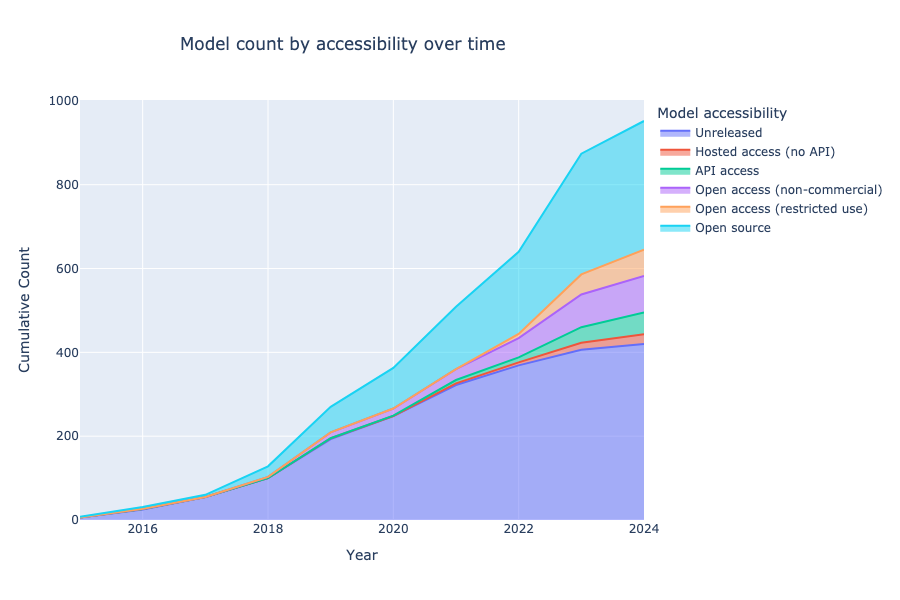

In [5]:
# Cumulative area chart
fig = px.area(access_counts, x='Year', y='Cumulative for status', color='Model accessibility', line_group='Model accessibility',
              labels={'Cumulative for status': 'Cumulative Count', 'Year': 'Year'},
              title='Model count by accessibility over time')

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    title_x=0.2,
)

# save_plot(fig, results_dir, f'cumulative_model_count_by_accessibility')

fig.show()

In [6]:
# Input -  model counts, grouped by accessibility and by year
# Output - same dataframe with cumulative counts for status and cumulative total across all statuses
def normalize_counts(access_counts):
    
    # Get df with total models per year, and cumulative totals
    total_counts = access_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
    total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
    
    # Pivot the access counts table to get counts for every status and every year
    # This will have many NaN values because not every year has a model of every status
    access_counts_wide = access_counts.pivot(index='Year', columns='Model accessibility', values='Cumulative for status')
    all_years = pd.Series(range(access_counts_wide.index.min(), access_counts_wide.index.max() + 1))

    # Fill in the NaN values
    access_counts_wide_filled = access_counts_wide.reindex(all_years).ffill().fillna(0)
    access_counts_wide_filled = access_counts_wide_filled.reset_index(names=["Year"])
    
    # Unpivot
    access_counts_filled = (access_counts_wide_filled.melt(id_vars='Year', 
                                     var_name='Model accessibility', 
                                     value_name='Cumulative for status')
                               .reset_index(drop=True))
    
    # Join with total counts df to get the cumulative totals
    normalized_counts = pd.merge(access_counts_filled, total_counts, on='Year')
    
    # Divide annual counts by cumulative counts to find cumulative proportions by year
    normalized_counts['proportion'] = normalized_counts['Cumulative for status'] / normalized_counts['Cumulative Total']
    
    # Sort using custom order
    sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open access (non-commercial)', 'Open access (restricted use)', 'Open source']
    normalized_counts['Category_sorted'] = pd.Categorical(normalized_counts['Model accessibility'], categories=sort_order, ordered=True)
    normalized_counts = normalized_counts.sort_values(['Category_sorted', 'Year'])
    
    return normalized_counts

In [7]:
normalized_counts = normalize_counts(access_counts)

normalized_counts.head(20)

Year     Model accessibility  Cumulative for status  Yearly Total  \
50  2015              Unreleased                    6.0             8   
51  2016              Unreleased                   25.0            23   
52  2017              Unreleased                   55.0            31   
53  2018              Unreleased                  100.0            67   
54  2019              Unreleased                  193.0           141   
55  2020              Unreleased                  248.0            95   
56  2021              Unreleased                  322.0           144   
57  2022              Unreleased                  369.0           131   
58  2023              Unreleased                  406.0           234   
59  2024              Unreleased                  420.0            78   
10  2015  Hosted access (no API)                    0.0             8   
11  2016  Hosted access (no API)                    1.0            23   
12  2017  Hosted access (no API)                    1.0            31   
13  2018  Hosted access (no API)                    1.0            67   
14  2019  Hosted access (no API)                    2.0           141   
15  2020  Hosted access (no API)                    2.0            95   
16  2021  Hosted access (no API)                    4.0           144   
17  2022  Hosted access (no API)                    7.0           131   
18  2023  Hosted access (no API)                   17.0           234   
19  2024  Hosted access (no API)                   23.0            78   

    Cumulative Total  proportion         Category_sorted  
50                 8    0.750000              Unreleased  
51                31    0.806452              Unreleased  
52                62    0.887097              Unreleased  
53               129    0.775194              Unreleased  
54               270    0.714815              Unreleased  
55               365    0.679452              Unreleased  
56               509    0.632613              Unreleased  
57               640    0.576562              Unreleased  
58               874    0.464531              Unreleased  
59               952    0.441176              Unreleased  
10                 8    0.000000  Hosted access (no API)  
11                31    0.032258  Hosted access (no API)  
12                62    0.016129  Hosted access (no API)  
13               129    0.007752  Hosted access (no API)  
14               270    0.007407  Hosted access (no API)  
15               365    0.005479  Hosted access (no API)  
16               509    0.007859  Hosted access (no API)  
17               640    0.010937  Hosted access (no API)  
18               874    0.019451  Hosted access (no API)  
19               952    0.024160  Hosted access (no API)

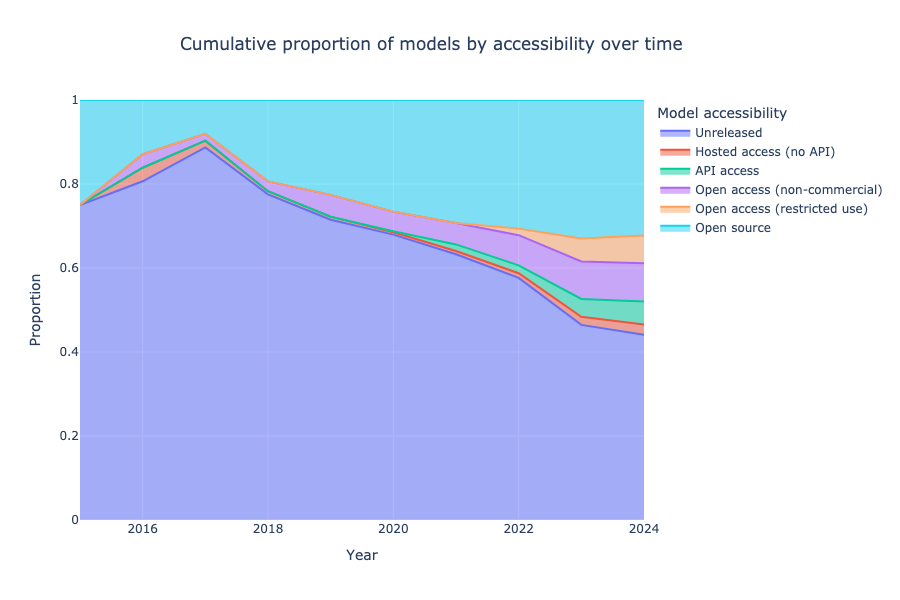

In [8]:
fig = px.area(normalized_counts, x='Year', y='proportion', color='Model accessibility', line_group='Model accessibility',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative proportion of models by accessibility over time')

fig.update_yaxes(range=[0, 1])
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    title_x=0.2,
)

# save_plot(fig, results_dir, f'proportion_by_accessibility')
fig.show()

# Code vs Model Accessibility

In [9]:
print(f"There are {len(access_df[access_df['Code accessibility'].isna()])} models with marked code access and unmarked code access")

There are 137 models with marked code access and unmarked code access


In [10]:
model_open_categories = ['Open source', 'Open access (restricted use)', 'Open access (non-commercial)']
code_open_categories = ['Open source', 'Open access (non-commercial)', 'Open access (restricted use)']


# Add open/closed binary columns
access_df['Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: 'Open' if x in model_open_categories else 'Closed'
)

access_df['Code open/closed'] = access_df['Code accessibility'].apply(
    # note that this defaults to Closed if NA
    lambda x: 'Open' if x in code_open_categories else 'Closed'
)

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_74801/1029345856.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/06/5htx0qw164j099bw2q7jk4gm0000gn/T/ipykernel_74801/1029345856.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
access_df.head(8)

System                                       Domain  \
0        Gemini 1.0 Ultra                   Multimodal,Language,Vision   
1                   GPT-4  Multimodal,Language,Vision,Image generation   
2           Mistral Large                                     Language   
3         Nemotron-4 340B                                     Language   
4  MegaScale (Production)                                     Language   
5            Inflection-2                                     Language   
6          Inflection-2.5                                     Language   
7                  PaLM 2                                     Language   

                                                Task Publication date  \
0  Language modelling,Visual question answering,C...       2023-12-06   
1                                 Language modelling       2023-03-15   
2                                               Chat       2024-02-26   
3                 Language modelling/generation,Chat       2024-06-14   
4                      Language modelling/generation       2024-02-23   
5  Language modelling,Language modelling/generati...       2023-11-22   
6                                               Chat       2024-03-07   
7   Language modelling,Language modelling/generation       2023-05-10   

                                 Accessibility notes     Model accessibility  \
0                                                NaN  Hosted access (no API)   
1                                                NaN              API access   
2                                                NaN              API access   
3  Permissive commercial license: https://develop...             Open source   
4  Code for MegaScale (also called veScale) train...              Unreleased   
5                                     via Pi, no API  Hosted access (no API)   
6                                                NaN  Hosted access (no API)   
7                                                NaN              API access   

  Dataset accessibility Code accessibility  \
0                   NaN         Unreleased   
1                   NaN         Unreleased   
2                   NaN         Unreleased   
3                   NaN                NaN   
4                   NaN         Unreleased   
5                   NaN         Unreleased   
6                   NaN         Unreleased   
7                   NaN         Unreleased   

                                                Link  \
0  https://storage.googleapis.com/deepmind-media/...   
1                   https://arxiv.org/abs/2303.08774   
2             https://mistral.ai/news/mistral-large/   
3  https://blogs.nvidia.com/blog/nemotron-4-synth...   
4                   https://arxiv.org/abs/2402.15627   
5                 https://inflection.ai/inflection-2   
6               https://inflection.ai/inflection-2-5   
7                   https://arxiv.org/abs/2305.10403   

                  Organization  ...  Training compute upper bound  \
0              Google DeepMind  ...                           NaN   
1                       OpenAI  ...                           NaN   
2                   Mistral AI  ...                           NaN   
3                       NVIDIA  ...                           NaN   
4  ByteDance,Peking University  ...                           NaN   
5                Inflection AI  ...                           NaN   
6                Inflection AI  ...                           NaN   
7                       Google  ...                           NaN   

  Training chip-hours Organization categorization (from Organization)  \
0         132000000.0                                        Industry   
1          57000000.0                                        Industry   
2                 NaN                                        Industry   
3                 NaN                                        Industry   
4                 NaN                               Industry,Acade

In [12]:
model_counts = access_df.groupby('Model accessibility').size().reset_index(name='Counts')
model_counts

Model accessibility  Counts
0                    API access      52
1        Hosted access (no API)      23
2  Open access (non-commercial)      87
3  Open access (restricted use)      63
4                   Open source     307
5                    Unreleased     439

In [13]:
code_counts = access_df.groupby('Code accessibility').size().reset_index(name='Counts')
code_counts

Code accessibility  Counts
0  Open access (non-commercial)      75
1  Open access (restricted use)       7
2                   Open source     332
3                    Unreleased     420

In [14]:
counts = access_df.groupby(['Model accessibility', 'Code accessibility']).size().reset_index(name='Counts')
pivoted = counts.pivot(index='Model accessibility', columns='Code accessibility', values='Counts').fillna(0).style.format("{:.0f}")

# code access against model access
pivoted

In [15]:
open_counts = access_df.groupby(['Model open/closed', 'Code open/closed']).size().reset_index(name='Counts')
open_counts = open_counts.pivot(index='Model open/closed', columns='Code open/closed', values='Counts')

# code open vs model open
open_counts

Code open/closed   Closed  Open
Model open/closed              
Closed                369   145
Open                  188   269

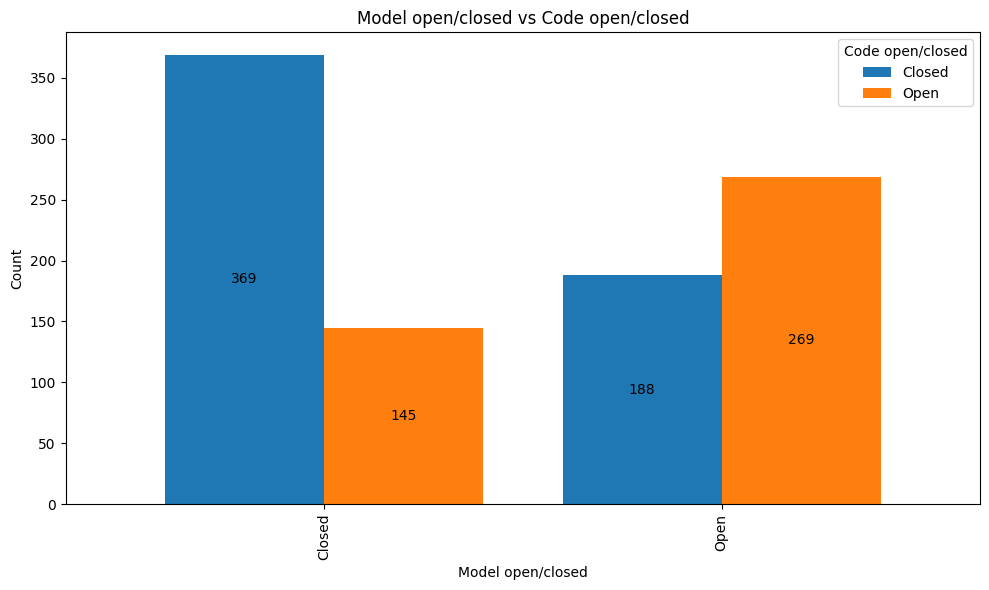

In [16]:
ax = open_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Customize the chart
plt.title('Model open/closed vs Code open/closed')
plt.ylabel('Count')


# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

In [20]:
open_counts = access_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model open/closed', 'Code open/closed']).size().reset_index(name='Count')

open_counts['Cumulative'] = open_counts.groupby(['Model open/closed', 'Code open/closed'])['Count'].cumsum()

open_counts.head(10)

Year Model open/closed Code open/closed  Count  Cumulative
0  2015            Closed           Closed      5           5
1  2015            Closed             Open      1           1
2  2015              Open             Open      2           2
3  2016            Closed           Closed     18          23
4  2016            Closed             Open      2           3
5  2016              Open           Closed      1           1
6  2016              Open             Open      2           4
7  2017            Closed           Closed     17          40
8  2017            Closed             Open     13          16
9  2017              Open             Open      1           5

In [21]:
total_counts = open_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
total_counts

Year  Yearly Total  Cumulative Total
0  2015             8                 8
1  2016            23                31
2  2017            31                62
3  2018            67               129
4  2019           141               270
5  2020            95               365
6  2021           144               509
7  2022           131               640
8  2023           234               874
9  2024            78               952

In [22]:
open_counts_wide = open_counts.pivot(index='Year', columns=['Model open/closed', 'Code open/closed'], values='Count')
open_counts_wide = open_counts_wide.fillna(0).reset_index()
open_counts_wide

Model open/closed  Year Closed        Open       
Code open/closed        Closed  Open  Open Closed
0                  2015    5.0   1.0   2.0    0.0
1                  2016   18.0   2.0   2.0    1.0
2                  2017   17.0  13.0   1.0    0.0
3                  2018   34.0  11.0  20.0    2.0
4                  2019   59.0  35.0  37.0   10.0
5                  2020   41.0  15.0  30.0    9.0
6                  2021   53.0  30.0  51.0   10.0
7                  2022   33.0  21.0  48.0   29.0
8                  2023   62.0  10.0  67.0   95.0
9                  2024   32.0   3.0  11.0   32.0

In [23]:
print(open_counts_wide.columns.to_list())
print(open_counts_wide.index.names)

[('Year', ''), ('Closed', 'Closed'), ('Closed', 'Open'), ('Open', 'Open'), ('Open', 'Closed')]
[None]


In [24]:
# Convert pivoted multi-columns to single columns with clear names
new_columns = ['Year'] + [f'Model {outer} Code {inner}' for outer, inner in open_counts_wide.columns[1:]]
open_counts_wide.columns = new_columns

open_counts_wide

Year  Model Closed Code Closed  Model Closed Code Open  \
0  2015                       5.0                     1.0   
1  2016                      18.0                     2.0   
2  2017                      17.0                    13.0   
3  2018                      34.0                    11.0   
4  2019                      59.0                    35.0   
5  2020                      41.0                    15.0   
6  2021                      53.0                    30.0   
7  2022                      33.0                    21.0   
8  2023                      62.0                    10.0   
9  2024                      32.0                     3.0   

   Model Open Code Open  Model Open Code Closed  
0                   2.0                     0.0  
1                   2.0                     1.0  
2                   1.0                     0.0  
3                  20.0                     2.0  
4                  37.0                    10.0  
5                  30.0                     9.0  
6                  51.0                    10.0  
7                  48.0                    29.0  
8                  67.0                    95.0  
9                  11.0                    32.0

In [25]:
# unpivot table to get the count of each 2x2 value for each year
open_counts_filled = (open_counts_wide.melt(id_vars=['Year'], 
                                            var_name='Category',
                                            value_name='Count')
                                      .reset_index(drop=True))

open_counts_filled.head(20)

Year                  Category  Count
0   2015  Model Closed Code Closed    5.0
1   2016  Model Closed Code Closed   18.0
2   2017  Model Closed Code Closed   17.0
3   2018  Model Closed Code Closed   34.0
4   2019  Model Closed Code Closed   59.0
5   2020  Model Closed Code Closed   41.0
6   2021  Model Closed Code Closed   53.0
7   2022  Model Closed Code Closed   33.0
8   2023  Model Closed Code Closed   62.0
9   2024  Model Closed Code Closed   32.0
10  2015    Model Closed Code Open    1.0
11  2016    Model Closed Code Open    2.0
12  2017    Model Closed Code Open   13.0
13  2018    Model Closed Code Open   11.0
14  2019    Model Closed Code Open   35.0
15  2020    Model Closed Code Open   15.0
16  2021    Model Closed Code Open   30.0
17  2022    Model Closed Code Open   21.0
18  2023    Model Closed Code Open   10.0
19  2024    Model Closed Code Open    3.0

In [26]:
open_counts_filled['Cumulative for Category'] = open_counts_filled.groupby('Category')['Count'].cumsum()

with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
with_totals['proportion'] = with_totals['Cumulative for Category'] / with_totals['Cumulative Total']
with_totals.head(20)

Year                  Category  Count  Cumulative for Category  \
0   2015  Model Closed Code Closed    5.0                      5.0   
1   2016  Model Closed Code Closed   18.0                     23.0   
2   2017  Model Closed Code Closed   17.0                     40.0   
3   2018  Model Closed Code Closed   34.0                     74.0   
4   2019  Model Closed Code Closed   59.0                    133.0   
5   2020  Model Closed Code Closed   41.0                    174.0   
6   2021  Model Closed Code Closed   53.0                    227.0   
7   2022  Model Closed Code Closed   33.0                    260.0   
8   2023  Model Closed Code Closed   62.0                    322.0   
9   2024  Model Closed Code Closed   32.0                    354.0   
10  2015    Model Closed Code Open    1.0                      1.0   
11  2016    Model Closed Code Open    2.0                      3.0   
12  2017    Model Closed Code Open   13.0                     16.0   
13  2018    Model Closed Code Open   11.0                     27.0   
14  2019    Model Closed Code Open   35.0                     62.0   
15  2020    Model Closed Code Open   15.0                     77.0   
16  2021    Model Closed Code Open   30.0                    107.0   
17  2022    Model Closed Code Open   21.0                    128.0   
18  2023    Model Closed Code Open   10.0                    138.0   
19  2024    Model Closed Code Open    3.0                    141.0   

    Yearly Total  Cumulative Total  proportion  
0              8                 8    0.625000  
1             23                31    0.741935  
2             31                62    0.645161  
3             67               129    0.573643  
4            141               270    0.492593  
5             95               365    0.476712  
6            144               509    0.445972  
7            131               640    0.406250  
8            234               874    0.368421  
9             78               952    0.371849  
10             8                 8    0.125000  
11            23                31    0.096774  
12            31                62    0.258065  
13            67               129    0.209302  
14           141               270    0.229630  
15            95               365    0.210959  
16           144               509    0.210216  
17           131               640    0.200000  
18           234               874    0.157895  
19            78               952    0.148109

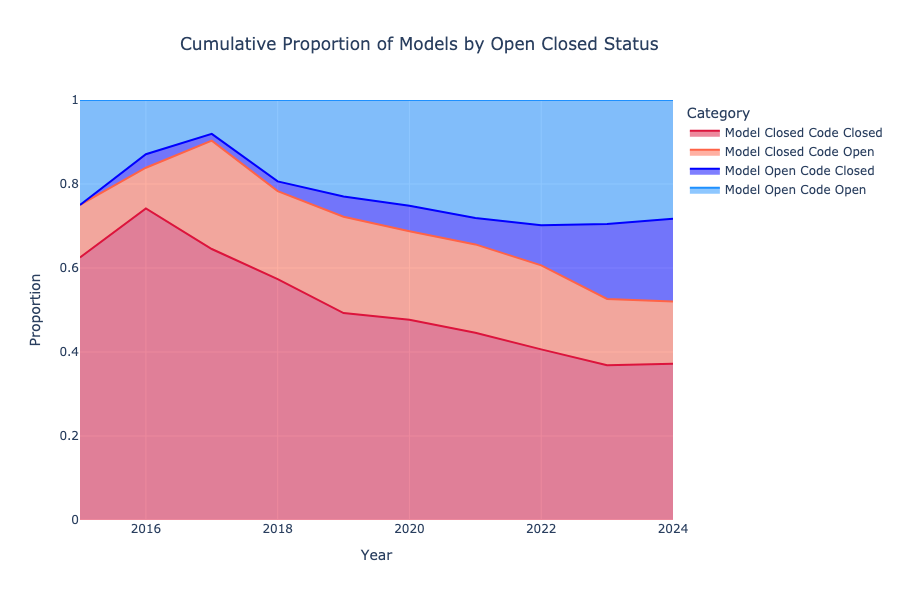

In [27]:
# sort using custom order
sort_order = ['Model Closed Code Closed', 'Model Closed Code Open', 'Model Open Code Closed', 'Model Open Code Open']

with_totals['Category_sorted'] = pd.Categorical(with_totals['Category'], categories=sort_order, ordered=True)
with_totals = with_totals.sort_values('Category_sorted')


colors = ['crimson', 'tomato', 'blue', 'dodgerblue']
fig = px.area(with_totals, x='Year', y='proportion', color='Category', line_group='Category',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative Proportion of Models by Open Closed Status', color_discrete_sequence=colors)

fig.update_yaxes(range=[0, 1])
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    title_x=0.2,
)
fig